### 1 What are 3 areas in industry where computer vision is currently being used?
In healthcare, computer vision is employed for medical image analysis, disease detection, and surgical assistance. It aids in diagnosing conditions from medical images such as X-rays, MRIs, and CT scans.

The automotive industry such as tesla utilizes computer vision for applications like advanced driver-assistance systems (ADAS), autonomous vehicles, and traffic monitoring. It enhances safety, navigation, and overall driving experience.
Retail:

Computer vision is employed in retailindustry  for tasks like inventory management, customer behavior analysis, and cashier-less checkout systems. It improve customer service, and enhance the shopping experience.



#### **2  Search "what is overfitting in machine learning" and write down a sentence about what you find.**
Overfitting in machine learning refers to a model learning the training data too well, capturing noise or random fluctuations in the data rather than the underlying patterns. This can result in poor generalization to new, unseen data.

**#### 3 Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. Note: there are lots of these, so don't worry too much about all of them, just pick 3 and start with those**.

1 regularalization
2 cross validation
3 data augmentation


#### 4**. Spend 20-minutes reading and clicking through the CNN Explainer website.**

**#### 5 5. Load the torchvision.datasets.MNIST() train and test datasets.**

In [1]:
#Import packages
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets, transforms

In [2]:
# Loading the MNIST dataset
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 143539739.01it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91285375.90it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36726487.44it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21381064.84it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
#Checking class name
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

#### **5 Visualize at least 5 different samples of the MNIST training dataset.**

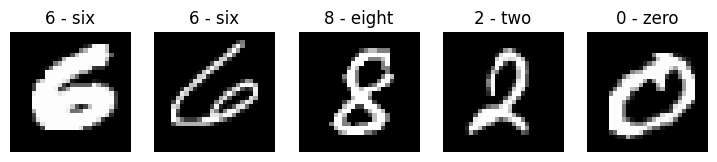

In [4]:
# Plot more images
import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 1, 5
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

#### **6 Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.**

In [5]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7eae23491120>, <torch.utils.data.dataloader.DataLoader object at 0x7eaef695ece0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [6]:
#view inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [7]:
#setting agnostic device
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

#### **8 Recreate model_2 used in notebook 03 (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.**

In [8]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_1 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [9]:
torch.manual_seed(42)
# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

#### **9 Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.**

In [10]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [11]:
# defining our helper function


def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)



In [12]:
#training on cpu
device = "cpu"
torch.manual_seed(42)

# Measure time on cpu
from timeit import default_timer as timer
train_time_start_on_cpu = timer()
#Setting number of epoch
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device = device
    )

train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.32017 | Train accuracy: 89.23%
Test loss: 0.07544 | Test accuracy: 97.72%

Epoch: 1
---------
Train loss: 0.08204 | Train accuracy: 97.48%
Test loss: 0.06162 | Test accuracy: 97.92%

Epoch: 2
---------
Train loss: 0.06394 | Train accuracy: 98.02%
Test loss: 0.05525 | Test accuracy: 98.10%

Epoch: 3
---------
Train loss: 0.05469 | Train accuracy: 98.27%
Test loss: 0.04741 | Test accuracy: 98.38%

Epoch: 4
---------
Train loss: 0.04825 | Train accuracy: 98.47%
Test loss: 0.04637 | Test accuracy: 98.35%

Train time on cpu: 196.486 seconds


In [13]:
torch.manual_seed(42)
device = "cuda"
#importing timer
from timeit import default_timer as timer
train_time_start_on_gpu = timer()


epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device = device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device = device
    )

train_time_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.04398 | Train accuracy: 98.62%
Test loss: 0.04586 | Test accuracy: 98.40%

Epoch: 1
---------
Train loss: 0.04002 | Train accuracy: 98.78%
Test loss: 0.05170 | Test accuracy: 98.40%

Epoch: 2
---------
Train loss: 0.03709 | Train accuracy: 98.88%
Test loss: 0.04417 | Test accuracy: 98.54%

Epoch: 3
---------
Train loss: 0.03556 | Train accuracy: 98.86%
Test loss: 0.04265 | Test accuracy: 98.56%

Epoch: 4
---------
Train loss: 0.03274 | Train accuracy: 98.95%
Test loss: 0.03847 | Test accuracy: 98.62%

Train time on cuda: 62.041 seconds


#### 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [14]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension for batch and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    #  turn list into a tensor
    return torch.stack(pred_probs)

In [15]:
#importing random
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=5):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [16]:
# Make predictions on test samples with model
pred_probs= make_predictions(model=model_1,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[3.3654e-11, 6.3648e-07, 1.0000e+00, 8.3091e-07, 2.4702e-15, 1.6457e-14,
         7.2130e-13, 2.0554e-07, 1.1635e-06, 8.5401e-12],
        [4.2266e-08, 9.9845e-01, 1.0355e-05, 3.3620e-07, 4.9008e-06, 9.4108e-05,
         6.9472e-05, 8.9273e-06, 1.2208e-03, 1.4037e-04]])

In [17]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6])

In [18]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6])

In [19]:
# Checking if  predictions is in the same form as our test labels
test_labels, pred_classes

([2, 1, 2, 4, 6], tensor([2, 1, 2, 4, 6]))

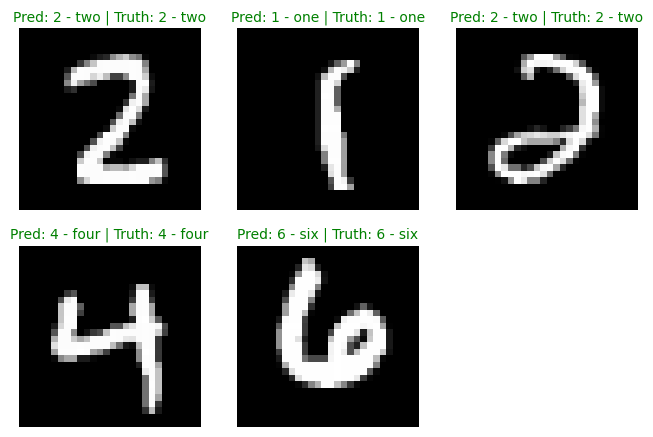

In [21]:
# Plot predictions
plt.figure(figsize=(8, 8))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

###### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [22]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [23]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


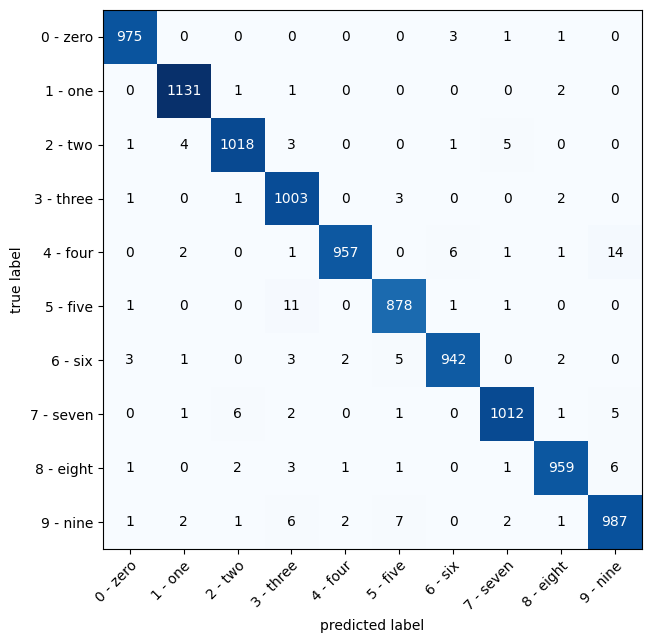

In [28]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [24]:
# Create a random tensor of shape [1, 3, 64, 64]
x = torch.rand((1, 3, 64, 64))

# Define a convolutional layer with different kernel sizes
conv1 = nn.Conv2d(3, 16, 3)
conv2 = nn.Conv2d(3, 16, 5)
conv3 = nn.Conv2d(3, 16, 7)

# Apply the convolutional layers to the input tensor
y1 = conv1(x)
y2 = conv2(x)
y3 = conv3(x)

# Print the shapes of the output tensors
print(y1.shape)
print(y2.shape)
print(y3.shape)




torch.Size([1, 16, 62, 62])
torch.Size([1, 16, 60, 60])
torch.Size([1, 16, 58, 58])


In [25]:
import torch.nn as nn

def count_model_parameters(model):
    """
    Counts the total and trainable parameters in a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    tuple: A tuple containing the total parameters and trainable parameters.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return total_params, trainable_params


In [29]:
count_model_parameters(conv1),count_model_parameters(conv2),count_model_parameters(conv3)

((448, 448), (1216, 1216), (2368, 2368))

In [30]:
import torch.nn as nn

def count_model_parameters(model):
    """
    Counts the total and trainable parameters in a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    tuple: A tuple containing the total parameters and trainable parameters.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return total_params, trainable_params


In [31]:
count_model_parameters(conv1),count_model_parameters(conv2),count_model_parameters(conv3)

((448, 448), (1216, 1216), (2368, 2368))

As the kernel size grows, the resulting output tensor diminishes. This is because the convolutional layer employs a sliding window across the input tensor, and the window's size dictates the coverage of each output pixel. With an increasing kernel size, the window encompasses more of the input tensor, leading to a reduction in the output tensor's size.

Furthermore, an escalation in kernel size corresponds to an augmentation in the number of parameters within the convolutional layer. This is attributed to the convolutional layer needing to learn distinct weights for each pixel in the output tensor. As the output tensor contracts in size, the pixel count decreases, resulting in a decline in the convolutional layer's parameter count.

In general, favoring a smaller kernel size for convolutional layers is advisable to enhance model efficiency by minimizing the overall parameter count. However, in scenarios where the input tensor is sizable, opting for a larger kernel size may be necessary to ensure comprehensive coverage of the entire input tensor.








###### 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.


In [34]:
fashion_test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
fashion_test_dataloader = DataLoader(fashion_test_data,batch_size=BATCH_SIZE,shuffle=False)

Checking for errors:   0%|          | 0/313 [00:00<?, ?it/s]

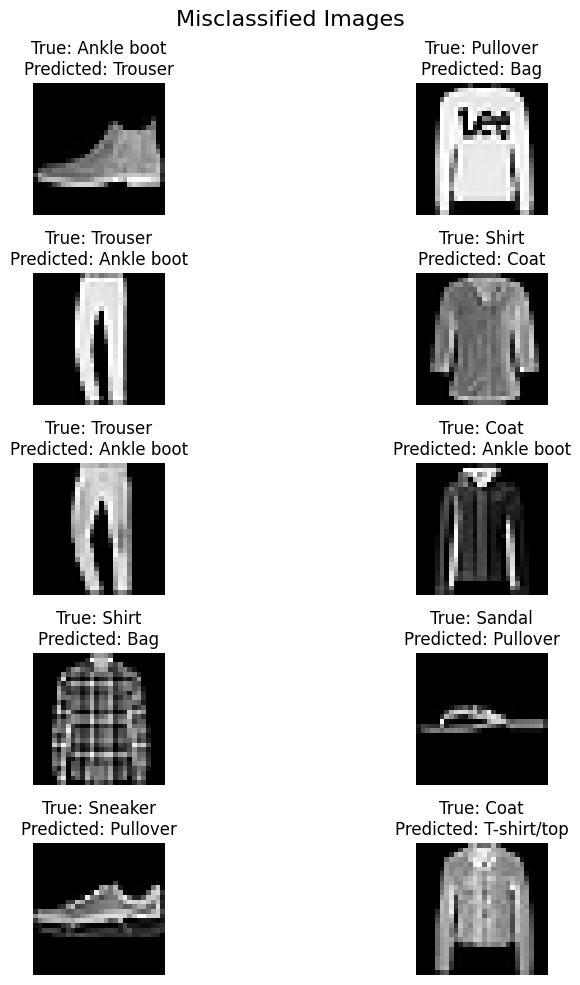

In [35]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Define class labels for FashionMNIST
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Make Predictions and Find Misclassifications
misclassified = []
with torch.inference_mode():
    for images, labels in tqdm(fashion_test_dataloader,desc="Checking for errors"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs, 1)
        misclassified += [(image, pred.item(), label.item()) for image, pred, label in zip(images, predicted, labels) if pred != label]

# Move misclassified images to CPU for plotting
misclassified = [(image.to("cpu"), pred, label) for image, pred, label in misclassified]

# Plot Images
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
fig.suptitle('Misclassified Images', fontsize=16)
for ax, (image, pred, label) in zip(axes.flatten(), misclassified[:10]):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"True: {classes[label]}\nPredicted: {classes[pred]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


#### the model still has a lot to learn because it couldnt make the right decisiom